# `CLOUD.jl` - 2D linear advection

In [1]:
using CLOUD
using Plots
using LinearAlgebra
using OrdinaryDiffEq
plots_path = "../plots/advection2d_demo/"
results_path = "../results/advection2d_demo/";

┌ Info: Precompiling CLOUD [fb992021-99c7-4c2d-a14b-5e48ac4045b2]
└ @ Base loading.jl:1342


Define the physical problem

In [16]:
a = (1.0,1.0)  # advection velocity
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = L  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation(a,λ=1.0);

Set up a weak-form quadrature-based DG scheme of degree `p` with `M` elements

In [17]:
M = 4  # number of elements
p = 3  # degree of discretization
reference_approximation=ReferenceApproximation(
    DGMulti(p), Tri());

In [18]:
spatial_discretization = SpatialDiscretization(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    (0.0,L), M), reference_approximation);

In [32]:
results_path = save_project(conservation_law,
     spatial_discretization, initial_data, StrongConservationForm(), 
     (0.0, 0.2*T), Eager(), results_path, overwrite=true, clear=true);

Run the `OrdinaryDiffEq` solver with RK4, taking `n_s` snapshots

In [33]:
n_s = 2
dt_scale=0.01
dt = dt_scale*(L/M)/(norm(a)*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
sol = solve(ode_problem, RK4(), adaptive=false,
    dt=dt, save_everystep=false,
    callback=save_callback(results_path, ceil(Int, T/(dt*n_s))))
save_solution(last(sol.u), last(sol.t), results_path, "final");

Visualize the solution and calculate the integral L<sup>2</sup> error norm

L2 error: 0.6205602146030298

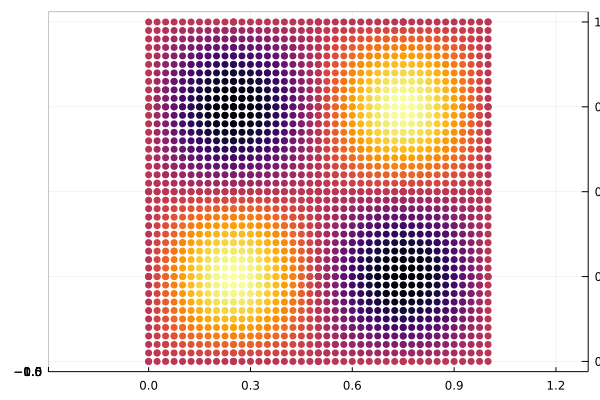

In [34]:
plotter = Plotter(spatial_discretization, plots_path)
error_analysis = ErrorAnalysis(conservation_law, spatial_discretization, results_path)
print("L2 error: ", analyze(error_analysis, last(sol.u), initial_data)[1])

visualize(initial_data,plotter, "exact.pdf")
#=visualize(last(sol.u), plotter,
    "final.pdf", exact_solution=initial_data,
     label="U^h(x,t)", label_exact="U(x,t)")=#

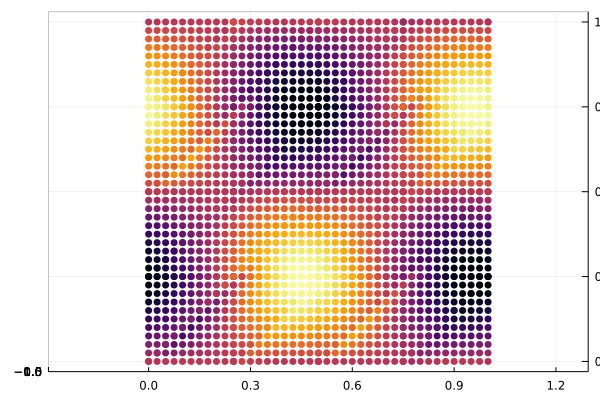

In [35]:
visualize(last(sol.u),plotter, "approx.pdf")